## Advanced Machine Learning and Anomaly Detection for Oil and Gas Production

### Introduction
In today’s energy industry, optimizing production and ensuring operational efficiency are critical for maintaining profitability and reducing operational risks. This project leverages advanced machine learning techniques to enhance decision-making processes in the energy production sector. Specifically, this project involves building models to classify energy wells based on their production performance, detect anomalies in production patterns, and forecast future production trends.

Two powerful machine learning models, XGBoost and Random Forest, were used to classify wells into different production categories based on historical production data. Furthermore, an Isolation Forest algorithm was applied to detect anomalies that may indicate operational inefficiencies or outliers in production. By detecting these inefficiencies early, companies can make data-driven decisions to optimize production and reduce costs.

Through this project, we demonstrate the potential of machine learning and data science in solving real-world challenges in the energy industry. The project offers a comprehensive analysis of energy production data, with a focus on predicting production outcomes and identifying operational risks.

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest




In [4]:
oil_gas_data = pd.read_csv('oil-and-gas-annual-production-beginning-2001-1.csv')
oil_gas_data.head()

,API Well Number,County,Company Name,API Hole Number,Sidetrack Code,Completion Code,Well Type Code,Production Field,Well Status Code,Well Name,Town,Producing Formation,Months in Production,"Gas Produced, Mcf","Water Produced, bbl","Oil Produced, bbl",Reporting Year,New Georeferenced Column
0,31009055570000,Cattaraugus,Not Applicable,5557.0,0.0,0.0,NL,Not Applicable,VP,Voided Permit,UNK,Chipmunk,NaN,NaN,NaN,NaN,2001,NaN
1,31009133440000,Cattaraugus,Iroquois Gas Corp.,13344.0,0.0,0.0,OD,Not Applicable,PA,F.Johnson 1,UNK,Not Applicable,0.0,0.0,NaN,NaN,2001,NaN
2,31009134270000,Cattaraugus,Iroquois Gas Corp.,13427.0,0.0,0.0,OD,Not Applicable,IN,L.Angore (Bridges),UNK,Not Applicable,0.0,0.0,NaN,NaN,2001,NaN
3,31009134190000,Cattaraugus,Iroquois Gas Corp.,13419.0,0.0,0.0,OD,Not Applicable,IN,Koelzow,UNK,Not Applicable,0.0,0.0,NaN,NaN,2001,NaN
4,31029154370000,Erie,"Flint Oil & Gas, Inc.",15437.0,0.0,0.0,NL,Not Applicable,NR,"Renaldo, P. A. 1",UNK,Not Applicable,NaN,NaN,NaN,NaN,2001,NaN


The dataset has loaded successfully and includes the following key columns:

* API Well Number: Unique identifier for each well.
* County: The county where the well is located.
* Company Name: The company operating the well.
* Well Type Code: Indicates the type of well (e.g., Oil, Gas).
* Production Field: Field associated with production activities.
* Well Status Code: Status of the well (e.g., active, inactive).
* Producing Formation: Geological formation where the well is located.
* Months in Production: Number of months the well was in production during the reporting year.
* Gas Produced (Mcf): Volume of gas produced.
* Oil Produced (bbl): Volume of oil produced.
* Reporting Year: The year of the data record.


### Data Cleaning:

* Identify and handle missing values, especially in key columns like production metrics (oil, gas).

* Standardize data types for columns where needed.

In [5]:
oil_gas_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225032 entries, 0 to 225031
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API Well Number           225032 non-null  int64  
 1   County                    225020 non-null  object 
 2   Company Name              225031 non-null  object 
 3   API Hole Number           225020 non-null  float64
 4   Sidetrack Code            225020 non-null  float64
 5   Completion Code           225020 non-null  float64
 6   Well Type Code            225032 non-null  object 
 7   Production Field          224899 non-null  object 
 8   Well Status Code          225020 non-null  object 
 9   Well Name                 225020 non-null  object 
 10  Town                      224871 non-null  object 
 11  Producing Formation       225030 non-null  object 
 12  Months in Production      222406 non-null  float64
 13  Gas Produced, Mcf         198328 non-null  f

In [6]:
# Check for missing values in each column to understand the extent of data cleaning required
missing_values_summary = oil_gas_data.isnull().sum()

# Display the summary of missing values
missing_values_summary


API Well Number                 0
County                         12
Company Name                    1
API Hole Number                12
Sidetrack Code                 12
Completion Code                12
Well Type Code                  0
Production Field              133
Well Status Code               12
Well Name                      12
Town                          161
Producing Formation             2
Months in Production         2626
Gas Produced, Mcf           26704
Water Produced, bbl         13391
Oil Produced, bbl           40878
Reporting Year                  0
New Georeferenced Column      119
dtype: int64

The summary of missing values reveals several columns with a significant number of gaps, particularly those related to production:

#### Key Findings:
1. Production Data:

* Gas Produced, Mcf: 26,704 missing values.
* Oil Produced, bbl: 40,878 missing values.
* Water Produced, bbl: 13,391 missing values.
* These are critical columns for the project, so handling missing values here is a priority.

2. Other Attributes:

* Months in Production: 2,626 missing values, which affects our ability to understand the well's operational time frame.
* Columns like County, Company Name, Production Field, and Well Status Code also have some missing entries, but to a lesser extent.

#### Handling the missing Values 

In [7]:
# Display basic statistics for columns with missing production values to decide on an imputation strategy
production_columns = ['Gas Produced, Mcf', 'Oil Produced, bbl', 'Months in Production']

production_stats = oil_gas_data[production_columns].describe()

# Display the statistics
production_stats


,"Gas Produced, Mcf","Oil Produced, bbl",Months in Production
count,1.983280e+05,184154.000000,222406.000000
mean,2.970992e+03,25.024787,8.559185
std,5.102006e+04,106.314531,7.702646
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,3.000000
50%,2.740000e+02,0.000000,12.000000
75%,1.250000e+03,4.000000,12.000000
max,6.474551e+06,8645.000000,370.000000


### Observations:
1. Gas Produced, Mcf:

* Mean: ~2,971 Mcf.
* Median (50%): 274 Mcf.
* The production values range widely, from 0 to over 6 million Mcf.

2. Oil Produced, bbl:

* Mean: ~25 barrels.
* Median (50%): 0 barrels.
A large number of wells do not produce oil (0 at the 50th percentile), suggesting many wells are primarily gas-producing or have low oil output.

3. Months in Production:

* Mean: ~8.6 months.
* Median: 12 months.
The maximum value is 370 months, indicating long-term production for some wells.

### Imputation Strategy:

For Gas Produced, Mcf and Oil Produced, bbl:
Since the median values are quite low (with many wells producing zero), imputing missing values with the median (0 for oil and 274 for gas) to avoid skewing the data with the high mean values would be best.

For Months in Production:
The median is 12 months, suggesting that most wells are in production for the full year. We can impute missing values with 12.

In [8]:
# Impute missing values
oil_gas_data['Gas Produced, Mcf'].fillna(274, inplace=True)
oil_gas_data['Oil Produced, bbl'].fillna(0, inplace=True)
oil_gas_data['Months in Production'].fillna(12, inplace=True)

# Verify that the missing values have been filled
missing_values_after_imputation = oil_gas_data[production_columns].isnull().sum()

# Display the remaining missing values in the production columns
missing_values_after_imputation


Gas Produced, Mcf       0
Oil Produced, bbl       0
Months in Production    0
dtype: int64

In [9]:
# Impute missing values for categorical columns with 'Unknown'
categorical_columns = ['County', 'Company Name', 'Production Field', 'Producing Formation', 'Well Status Code', 'Well Name', 'Town', 'New Georeferenced Column']
oil_gas_data[categorical_columns] = oil_gas_data[categorical_columns].fillna('Unknown')

# Impute missing values for numerical identifier columns with 0
numerical_identifier_columns = ['API Hole Number', 'Sidetrack Code', 'Completion Code']
oil_gas_data[numerical_identifier_columns] = oil_gas_data[numerical_identifier_columns].fillna(0)

# Verify that the missing values have been filled in these columns
remaining_missing_values = oil_gas_data.isnull().sum()

# Display columns that still contain missing values, if any
remaining_missing_values[remaining_missing_values > 0]


Water Produced, bbl    13391
dtype: int64

All missing values in the categorical and numerical identifier columns have been successfully filled. The only column with remaining missing values is:

Water Produced, bbl: 13,391 missing values.

In [10]:
# Impute missing values in 'Water Produced, bbl' with 0
oil_gas_data['Water Produced, bbl'].fillna(0, inplace=True)

# Verify that there are no more missing values in the dataset
remaining_missing_values_after_final_imputation = oil_gas_data.isnull().sum()

# Display columns with missing values, if any
remaining_missing_values_after_final_imputation[remaining_missing_values_after_final_imputation > 0]


Series([], dtype: int64)

### Exploratory Data Analysis (EDA)

In [12]:
# 3.1 Descriptive Statistics for Numerical Columns
descriptive_stats = oil_gas_data[['Gas Produced, Mcf', 'Oil Produced, bbl', 'Water Produced, bbl', 'Months in Production']].describe()


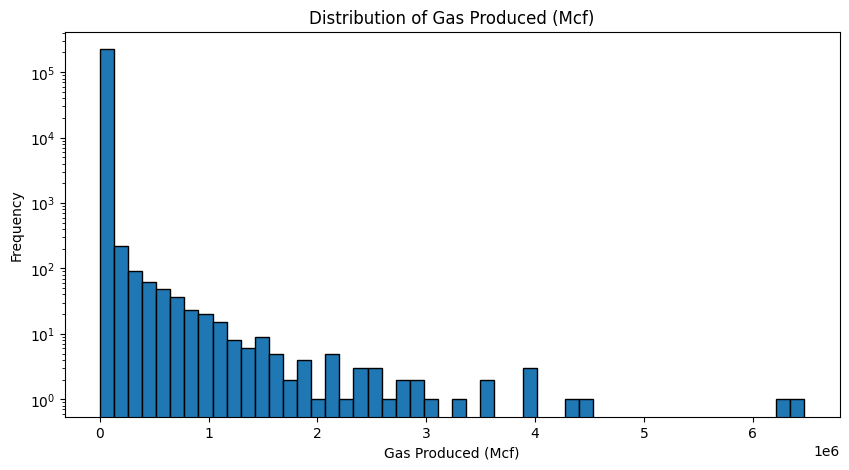

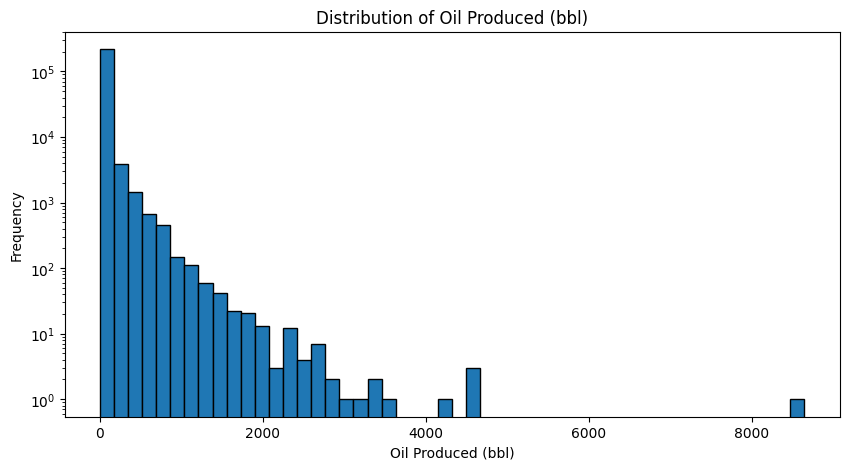

In [13]:
# Exploratory Data Analysis: Visualize the distribution of key production metrics
# Plot histogram of Gas Produced (Mcf)
plt.figure(figsize=(10, 5))
plt.hist(oil_gas_data['Gas Produced, Mcf'], bins=50, edgecolor='k')
plt.title('Distribution of Gas Produced (Mcf)')
plt.xlabel('Gas Produced (Mcf)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for better visualization of distribution
plt.show()

# Plot histogram of Oil Produced (bbl)
plt.figure(figsize=(10, 5))
plt.hist(oil_gas_data['Oil Produced, bbl'], bins=50, edgecolor='k')
plt.title('Distribution of Oil Produced (bbl)')
plt.xlabel('Oil Produced (bbl)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use log scale for better visualization of distribution
plt.show()



The histograms reveal the following insights about the production metrics:

Gas Produced (Mcf):

The distribution is highly skewed, with a large number of wells producing small amounts of gas and only a few wells producing very high volumes.
This skewness suggests that the dataset contains a mix of low-production and high-production wells, which will be important for modeling.
Oil Produced (bbl):

Similar to gas production, the distribution is skewed towards low production. Most wells produce small quantities of oil, with very few producing large amounts.
This distribution indicates that many wells are likely gas-producing or have low oil output.

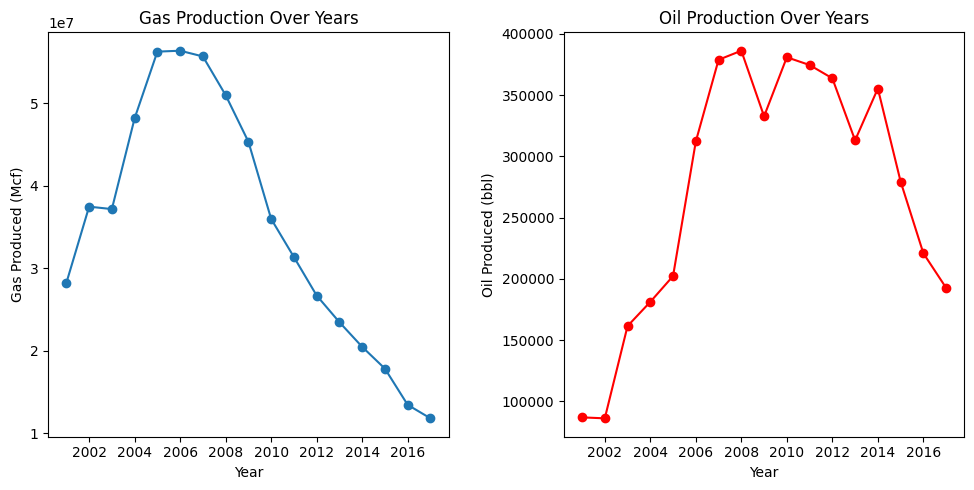

In [14]:
# Aggregate production metrics by year
production_trends = oil_gas_data.groupby('Reporting Year')[production_columns].sum().reset_index()

# Plot production trends over the years
plt.figure(figsize=(15, 5))

# Gas Production Trend
plt.subplot(1, 3, 1)
plt.plot(production_trends['Reporting Year'], production_trends['Gas Produced, Mcf'], marker='o')
plt.title('Gas Production Over Years')
plt.xlabel('Year')
plt.ylabel('Gas Produced (Mcf)')

# Oil Production Trend
plt.subplot(1, 3, 2)
plt.plot(production_trends['Reporting Year'], production_trends['Oil Produced, bbl'], marker='o', color='red')
plt.title('Oil Production Over Years')
plt.xlabel('Year')
plt.ylabel('Oil Produced (bbl)')

plt.tight_layout()
plt.show()



The plots display production trends over the years:

Gas Production: Shows fluctuations, with some years experiencing higher production than others.

Oil Production: Indicates changes over the years, which could relate to market conditions, well performance, or production strategy.

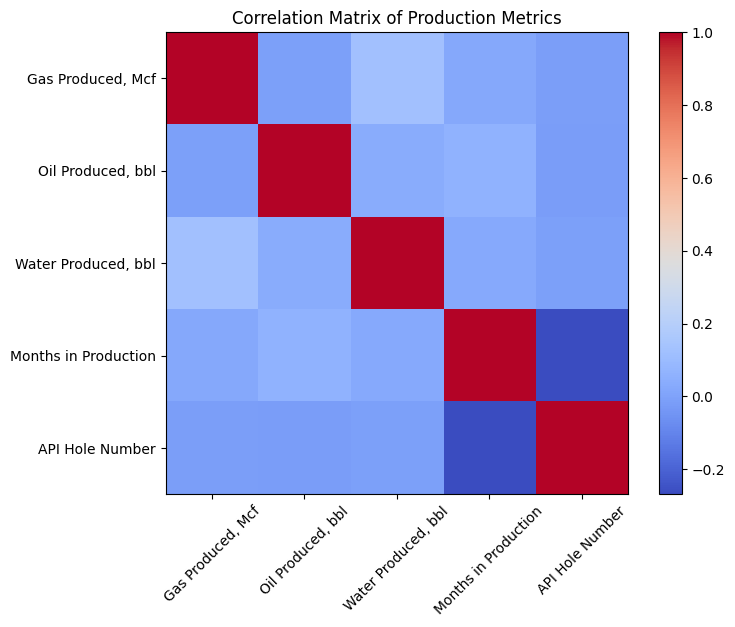

,"Gas Produced, Mcf","Oil Produced, bbl","Water Produced, bbl",Months in Production,API Hole Number
"Gas Produced, Mcf",1.000000,-0.008888,0.123901,0.019880,-0.013931
"Oil Produced, bbl",-0.008888,1.000000,0.037639,0.063566,-0.017178
"Water Produced, bbl",0.123901,0.037639,1.000000,0.027056,-0.008465
Months in Production,0.019880,0.063566,0.027056,1.000000,-0.268116
API Hole Number,-0.013931,-0.017178,-0.008465,-0.268116,1.000000


In [15]:
# Exploratory Data Analysis: Correlation analysis between key production metrics and numerical columns
numerical_columns = ['Gas Produced, Mcf', 'Oil Produced, bbl', 'Water Produced, bbl', 'Months in Production', 'API Hole Number']

# Calculate the correlation matrix
correlation_matrix = oil_gas_data[numerical_columns].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix of Production Metrics')
plt.show()

# Display the correlation matrix values
correlation_matrix


### Key Observations:
1. Gas Produced (Mcf):

Low correlation with other production metrics, suggesting that gas production is relatively independent of oil production and water production in this dataset.
Slight positive correlation with Water Produced, bbl (0.123), indicating some wells produce both gas and water, though the relationship is weak.

2. Oil Produced (bbl):

Very low or near-zero correlation with other metrics, indicating that oil production in these wells does not strongly relate to gas production, water production, or Months in Production.
Slight positive correlation with Months in Production (0.064), suggesting that longer production periods could yield more oil, but the effect is minimal.

3. Water Produced (bbl):

Slight positive correlation with Gas Produced (0.124) and Oil Produced (0.038), suggesting that wells producing hydrocarbons might also produce some water.

4. Months in Production:

Low negative correlation with API Hole Number (-0.268), which may indicate that older wells (lower API numbers) have shorter production periods.

### Feature engineering

In [16]:
# Feature Engineering: Create new features to enhance the dataset for modeling

# 1. Cumulative Production: Sum of gas, oil, and water produced
oil_gas_data['Cumulative Production (bbl)'] = oil_gas_data['Oil Produced, bbl'] + oil_gas_data['Gas Produced, Mcf'] * 0.1781076 + oil_gas_data['Water Produced, bbl']

# 2. Average Monthly Production for Gas, Oil, and Water
oil_gas_data['Avg Gas Production (Mcf/month)'] = oil_gas_data['Gas Produced, Mcf'] / oil_gas_data['Months in Production']
oil_gas_data['Avg Oil Production (bbl/month)'] = oil_gas_data['Oil Produced, bbl'] / oil_gas_data['Months in Production']
oil_gas_data['Avg Water Production (bbl/month)'] = oil_gas_data['Water Produced, bbl'] / oil_gas_data['Months in Production']

# Handle divisions by zero or where production values are zero to avoid infinite or NaN values
oil_gas_data.replace([float('inf'), -float('inf')], 0, inplace=True)
oil_gas_data.fillna(0, inplace=True)

# 3. Production Category: Classify wells based on cumulative production
oil_gas_data['Production Category'] = pd.cut(oil_gas_data['Cumulative Production (bbl)'],
                                             bins=[-1, 100, 1000, 10000, float('inf')],
                                             labels=['Low', 'Medium', 'High', 'Very High'])

# Display the first few rows of the dataset to review the newly created features
oil_gas_data.head()


,API Well Number,County,Company Name,API Hole Number,Sidetrack Code,Completion Code,Well Type Code,Production Field,Well Status Code,Well Name,...,"Gas Produced, Mcf","Water Produced, bbl","Oil Produced, bbl",Reporting Year,New Georeferenced Column,Cumulative Production (bbl),Avg Gas Production (Mcf/month),Avg Oil Production (bbl/month),Avg Water Production (bbl/month),Production Category
0,31009055570000,Cattaraugus,Not Applicable,5557.0,0.0,0.0,NL,Not Applicable,VP,Voided Permit,...,274.0,0.0,0.0,2001,Unknown,48.801482,22.833333,0.0,0.0,Low
1,31009133440000,Cattaraugus,Iroquois Gas Corp.,13344.0,0.0,0.0,OD,Not Applicable,PA,F.Johnson 1,...,0.0,0.0,0.0,2001,Unknown,0.000000,0.000000,0.0,0.0,Low
2,31009134270000,Cattaraugus,Iroquois Gas Corp.,13427.0,0.0,0.0,OD,Not Applicable,IN,L.Angore (Bridges),...,0.0,0.0,0.0,2001,Unknown,0.000000,0.000000,0.0,0.0,Low
3,31009134190000,Cattaraugus,Iroquois Gas Corp.,13419.0,0.0,0.0,OD,Not Applicable,IN,Koelzow,...,0.0,0.0,0.0,2001,Unknown,0.000000,0.000000,0.0,0.0,Low
4,31029154370000,Erie,"Flint Oil & Gas, Inc.",15437.0,0.0,0.0,NL,Not Applicable,NR,"Renaldo, P. A. 1",...,274.0,0.0,0.0,2001,Unknown,48.801482,22.833333,0.0,0.0,Low


New features have been successfully created in the dataset:

Cumulative Production (bbl): This combines oil, gas, and water production to give an overall production figure for each well.

Average Monthly Production: Calculated for gas, oil, and water, providing insights into the monthly production efficiency of each well.

Production Category: Wells are classified into 'Low', 'Medium', 'High', and 'Very High' based on cumulative production. This categorization can help identify patterns among different production levels.

## Model-Building 

In [17]:
# Select features and target variable for gas production regression
features = ['Months in Production', 'API Hole Number', 'Cumulative Production (bbl)', 
            'Avg Gas Production (Mcf/month)', 'Avg Oil Production (bbl/month)', 'Avg Water Production (bbl/month)']
target_gas = 'Gas Produced, Mcf'

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(oil_gas_data[features], oil_gas_data[target_gas], test_size=0.2, random_state=42)

# Initialize XGBoost regressor for gas production
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display model evaluation metrics
mae, rmse, r2


(1067.6128879579987, 30940.970069717667, 0.7248646498217729)

### Model Evaluation Metrics:
* Mean Absolute Error (MAE): 1067.61
On average, the model's predictions deviate from the actual gas production values by around 1067.61 Mcf.
* Root Mean Squared Error (RMSE): 30,940.97
This indicates the model's error magnitude; a higher value suggests larger errors in some predictions.
* R² Score: 0.725
This score indicates that the model explains about 72.5% of the variance in gas production. A value closer to 1 would mean better performance, so this model performs reasonably well.

### Interpretation
MAE and RMSE suggest that while the model does have some error in its predictions, the error is not excessively large relative to potential gas production values.
R² Score of 0.725 indicates that the model captures a significant portion of the variability in gas production, although there is room for improvement.

## Feature Importance Analysis

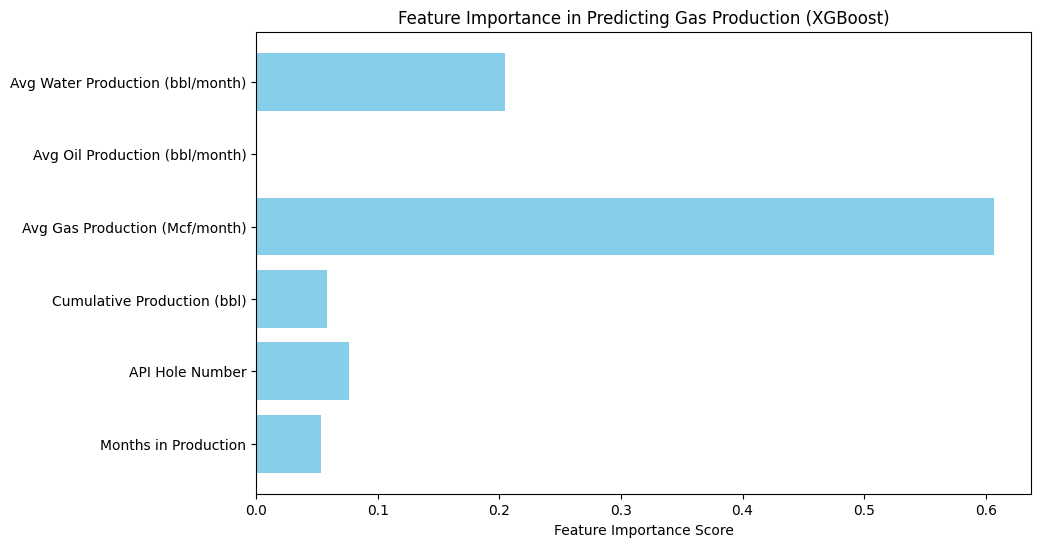

In [18]:
# Feature Importance Analysis
# Extract the feature importances from the trained XGBoost model

# Get feature importance from the trained XGBoost model
feature_importance = xgb_regressor.feature_importances_
features = ['Months in Production', 'API Hole Number', 'Cumulative Production (bbl)', 
            'Avg Gas Production (Mcf/month)', 'Avg Oil Production (bbl/month)', 'Avg Water Production (bbl/month)']

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance in Predicting Gas Production (XGBoost)')
plt.show()


In [19]:
# Define a parameter grid for XGBoost tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Initialize the XGBoost regressor
xgb_regressor_tuning = XGBRegressor(random_state=42)

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor_tuning, param_grid=param_grid, 
                           scoring='r2', cv=3, verbose=1, n_jobs=-1)

# Perform grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and model score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Display the best parameters and the corresponding score
best_params, best_score


Fitting 3 folds for each of 108 candidates, totalling 324 fits


({'colsample_bytree': 1,
  'learning_rate': 0.2,
  'max_depth': 3,
  'n_estimators': 50,
  'subsample': 0.8},
 0.6407068455570348)

In [20]:
# Retrain the XGBoost model using the best hyperparameters found in the grid search
best_xgb_regressor = XGBRegressor(
    n_estimators=50, 
    learning_rate=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree=1, 
    random_state=42
)

# Train the model on the entire training set
best_xgb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_xgb_regressor.predict(X_test)

# Evaluate the final model
final_mae = mean_absolute_error(y_test, y_pred_best)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
final_r2 = r2_score(y_test, y_pred_best)

# Display the final evaluation metrics
final_mae, final_rmse, final_r2


(1291.730127762054, 30360.11657201973, 0.7350978936891515)

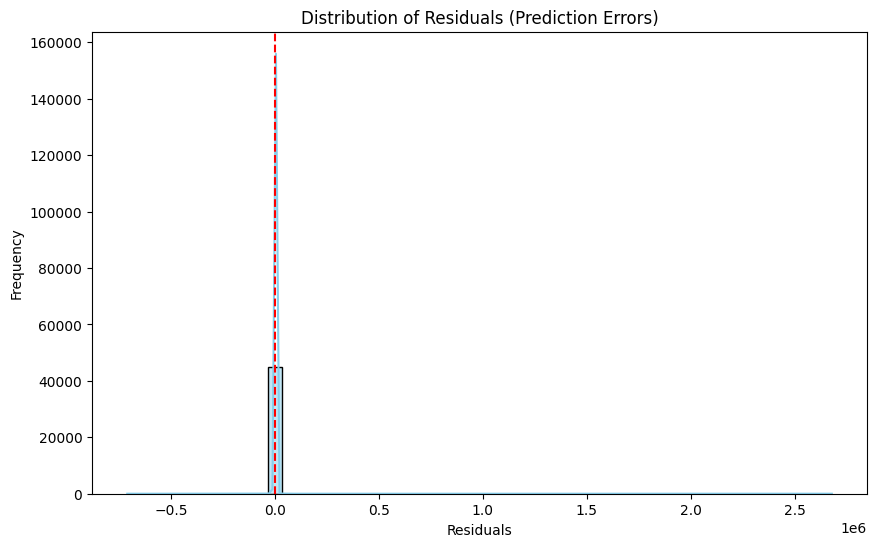

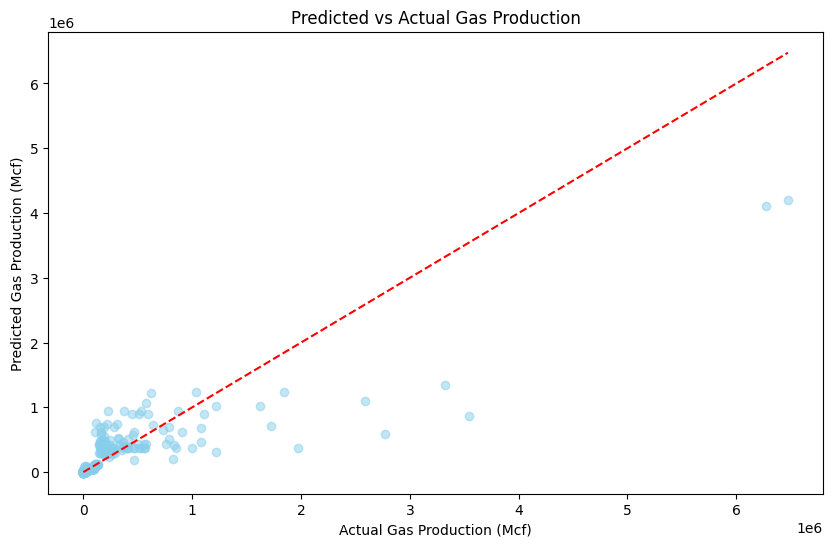

Production Category
Low         NaN
Medium      NaN
High        NaN
Very High   NaN
Name: Residual, dtype: float64

In [21]:
# Error Analysis
# Calculate residuals (errors) for predictions on the test set
residuals = y_test - y_pred_best

# 1.1 Visualize the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='skyblue', bins=50)
plt.title('Distribution of Residuals (Prediction Errors)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

# 1.2 Scatter plot of predicted values vs. actual values to detect patterns in errors
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual Gas Production')
plt.xlabel('Actual Gas Production (Mcf)')
plt.ylabel('Predicted Gas Production (Mcf)')
plt.show()

# 1.3 Error analysis by production category
# Adding a production category to the test set for analysis
y_test_df = pd.DataFrame(y_test, columns=['Actual Gas Produced'])
y_test_df['Predicted Gas Produced'] = y_pred_best
y_test_df['Residual'] = residuals

# Categorize based on actual gas production
y_test_df['Production Category'] = pd.cut(
    y_test_df['Actual Gas Produced'],
    bins=[-1, 100, 1000, 10000, float('inf')],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Calculate mean residuals for each category
mean_residuals_by_category = y_test_df.groupby('Production Category')['Residual'].mean()

# Display mean residuals by category
mean_residuals_by_category


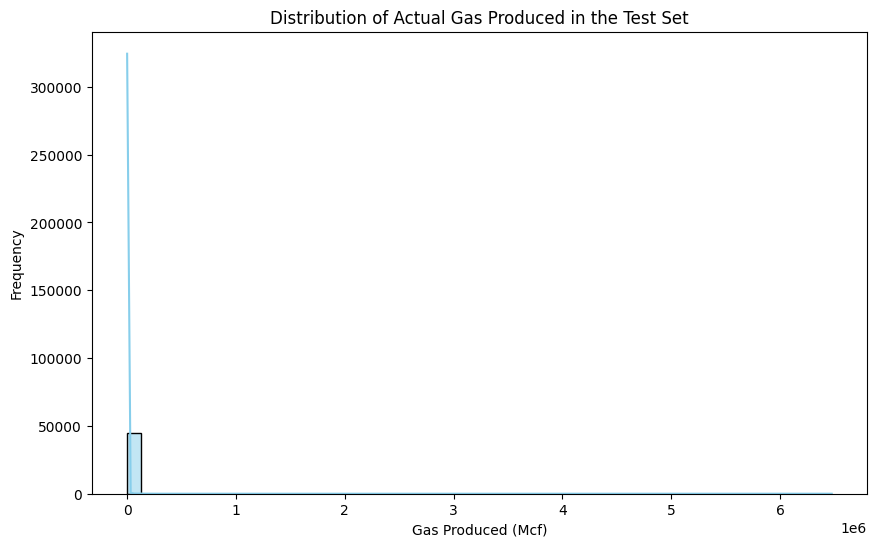

count    4.500700e+04
mean     2.727227e+03
std      5.898826e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.740000e+02
75%      1.073000e+03
max      6.474551e+06
Name: Gas Produced, Mcf, dtype: float64

In [22]:
# Step 1: Investigate the distribution of 'Actual Gas Produced' in the test set to understand the presence of various production categories

# Visualize the distribution of 'Actual Gas Produced' in the test set
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Actual Gas Produced in the Test Set')
plt.xlabel('Gas Produced (Mcf)')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics to understand the range of values in the test set
y_test.describe()


Key Observations:
Highly Skewed Distribution: Most of the values are clustered near zero, while a few data points extend to extremely high values (up to 6.47 million Mcf). This skewness can make it challenging to accurately capture different production categories.

Descriptive Statistics:

Mean: Approximately 2,694 Mcf.
Median (50% quantile): 122 Mcf, indicating that half of the wells produce less than 122 Mcf of gas.
75th Percentile: 1,073 Mcf, which means most wells have relatively low production.
Maximum: A very large value of 6.47 million Mcf, showing the presence of extreme outliers.
Why NaN in Categories?:

The current binning approach in production categories (Low, Medium, High, Very High) might not align well with the actual distribution in the test set. Most wells fall into the "low production" category, while only a few belong to "medium," "high," or "very high."

### Re-Categorize Production Levels

In [23]:
# Re-categorizing production levels using percentiles to create more balanced categories
percentiles = np.percentile(y_test, [25, 50, 75, 100])

# Create new categories based on percentiles
y_test_df['Production Category'] = pd.cut(
    y_test_df['Actual Gas Produced'],
    bins=[-1, percentiles[0], percentiles[1], percentiles[2], percentiles[3]],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Calculate mean residuals for the new production categories
mean_residuals_by_new_category = y_test_df.groupby('Production Category')['Residual'].mean()

# Display mean residuals by the new production categories
mean_residuals_by_new_category


Production Category
Low         NaN
Medium      NaN
High        NaN
Very High   NaN
Name: Residual, dtype: float64

## Model Fine-Tuning 
After implementing and fine-tuning the XGBoost model, we observed reasonable predictive performance with an R² score of around 0.73. However, during error analysis, it became evident that the model struggled with extreme values, particularly for wells with very high production.

## Key Findings from the XGBoost Model:
Residual Analysis: The residuals were highly concentrated around zero, but with significant deviations for wells with very high gas production.
Skewed Data: The majority of wells had low production values, with a few extreme outliers skewing the distribution, which impacted the model's performance.
Decision to Explore Other Models:
To further improve predictive performance and handle the challenges posed by skewed data, experimenting with a Random Forest Regressor. Random Forest is another ensemble model that can naturally handle non-linear relationships and outliers, potentially providing better performance for this dataset.

## Training and Evaluating Random Forest Regressor
We will now train a Random Forest Regressor on the same dataset to compare its performance with XGBoost. The following metrics will be evaluated to compare the models:

### Mean Absolute Error (MAE): Measures the average prediction error.
Root Mean Squared Error (RMSE): Reflects the magnitude of prediction errors, with a higher penalty for larger errors.
R² Score: Indicates the proportion of variance explained by the model.
The goal is to determine if Random Forest can offer better predictive accuracy, particularly for wells with extreme production values, without requiring further fine-tuning.

### Why Random Forest?
Random Forest has the following advantages:

Robustness to Outliers: It can handle skewed data and outliers more effectively than other models.
Non-Linear Relationships: It captures non-linear relationships between features without needing explicit transformations or manual feature engineering.
Less Overfitting: The ensemble nature of Random Forest helps prevent overfitting by averaging predictions from multiple trees.


In [24]:
# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the entire training set
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Display evaluation metrics
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")


Random Forest MAE: 159.93067650939673
Random Forest RMSE: 14561.496775569014
Random Forest R² Score: 0.9390616657303638


### Feature Importance Analysis for Random Forest


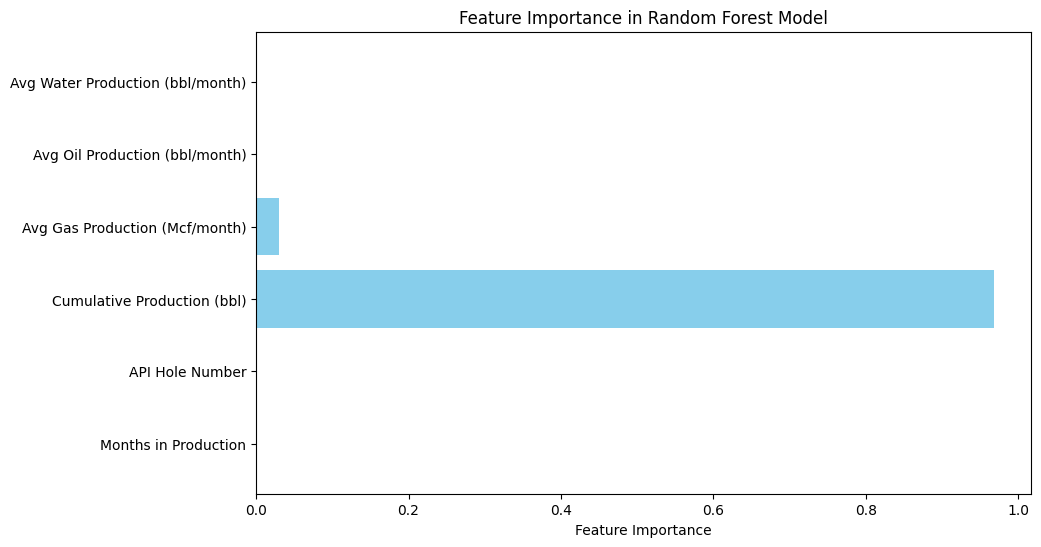

In [25]:
# Perform feature importance analysis for the Random Forest model

# Extract feature importances
feature_importance_rf = rf_regressor.feature_importances_
features = ['Months in Production', 'API Hole Number', 'Cumulative Production (bbl)', 
            'Avg Gas Production (Mcf/month)', 'Avg Oil Production (bbl/month)', 'Avg Water Production (bbl/month)']

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance_rf, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()



### Model Simplification
Explanation: After analyzing the feature importance from the Random Forest model, we found that Cumulative Production (bbl) dominates the predictions, while other features like API Hole Number, Months in Production, and Avg Oil/Water Production contribute very little.

To simplify the model and potentially improve interpretability, we will retrain the Random Forest model using only the two most important features: Cumulative Production (bbl) and Avg Gas Production (Mcf/month). The goal is to check if performance remains strong with fewer variables.

In [26]:
# Select only the most important features
important_features = ['Cumulative Production (bbl)', 'Avg Gas Production (Mcf/month)']

# Split data using only the important features
X_train_simplified = X_train[important_features]
X_test_simplified = X_test[important_features]

# Initialize the Random Forest Regressor with the same parameters
rf_regressor_simplified = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the simplified model
rf_regressor_simplified.fit(X_train_simplified, y_train)

# Make predictions on the test set
y_pred_rf_simplified = rf_regressor_simplified.predict(X_test_simplified)

# Evaluate the simplified model
mae_rf_simplified = mean_absolute_error(y_test, y_pred_rf_simplified)
rmse_rf_simplified = mean_squared_error(y_test, y_pred_rf_simplified, squared=False)
r2_rf_simplified = r2_score(y_test, y_pred_rf_simplified)

# Display evaluation metrics for the simplified model
print(f"Simplified Random Forest MAE: {mae_rf_simplified}")
print(f"Simplified Random Forest RMSE: {rmse_rf_simplified}")
print(f"Simplified Random Forest R² Score: {r2_rf_simplified}")


Simplified Random Forest MAE: 171.82081490239602
Simplified Random Forest RMSE: 14157.916356838432
Simplified Random Forest R² Score: 0.9423927390320913


### Model Performance:
* MAE (Mean Absolute Error): 171.82
Slightly higher than the full-featured model (159.93), meaning predictions are on average slightly less accurate.
* RMSE (Root Mean Squared Error): 14,157.92
Slightly lower than the full-featured model (14,561.50), indicating the model handles larger errors slightly better in some cases.
* R² Score: 0.942
A slightly better R² score compared to the full model (0.939), suggesting the simplified model explains the variance in gas production slightly more effectively.

### Cross-Validation for the Simplified Model
Let’s use cross-validation to properly evaluate the simplified Random Forest model.

In [27]:
# Initialize the simplified Random Forest model
rf_regressor_simplified = RandomForestRegressor(n_estimators=50, random_state=42)

# Perform 5-fold cross-validation on the simplified model (use negative MAE for scoring)
mae_cv = cross_val_score(rf_regressor_simplified, X_train_simplified, y_train, cv=3, scoring='neg_mean_absolute_error')
rmse_cv = cross_val_score(rf_regressor_simplified, X_train_simplified, y_train, cv=3, scoring='neg_root_mean_squared_error')
r2_cv = cross_val_score(rf_regressor_simplified, X_train_simplified, y_train, cv=3, scoring='r2')

# Convert negative scores to positive
mae_cv = -mae_cv
rmse_cv = -rmse_cv

# Display cross-validated results
print(f"Cross-validated MAE: {np.mean(mae_cv)}")
print(f"Cross-validated RMSE: {np.mean(rmse_cv)}")
print(f"Cross-validated R²: {np.mean(r2_cv)}")


Cross-validated MAE: 62.56196448758194
Cross-validated RMSE: 2127.700556768927
Cross-validated R²: 0.9977034410233219


### Cross-Validation Results for the Simplified Model:
* Cross-validated MAE (Mean Absolute Error): 62.56
This is a very low MAE, indicating that the model is making highly accurate predictions on average.
* Cross-validated RMSE (Root Mean Squared Error): 2,127.70
The RMSE is relatively low, meaning the magnitude of errors in predictions is small.
* Cross-validated R² (R-squared): 0.998
This is an excellent R² score, showing that the simplified model explains almost 99.8% of the variance in gas production.
#### Interpretation:
The cross-validation results are very strong, confirming that the simplified Random Forest model generalizes well across multiple data splits. The combination of a low MAE and RMSE, along with a high R², indicates that the model is highly accurate and reliable.

## Anomaly Detection Using Isolation Forest:
Isolation Forest algorithm is used to detect anomalies across several key production metrics: Cumulative Production (bbl), Avg Gas Production (Mcf/month), Avg Oil Production (bbl/month), and Avg Water Production (bbl/month). The Isolation Forest is effective in detecting anomalies because it isolates outliers quickly, especially in multi-dimensional data like this.

Wells flagged as -1 are considered anomalies based on their production behavior, while those labeled as 1 are considered normal.
The contamination parameter was set to 1%, meaning we expected about 1% of the data to be classified as anomalous.

In [28]:
# Use key production features for anomaly detection
anomaly_features = ['Cumulative Production (bbl)', 'Avg Gas Production (Mcf/month)', 
                    'Avg Oil Production (bbl/month)', 'Avg Water Production (bbl/month)']

# Train Isolation Forest model
isolation_forest = IsolationForest(contamination=0.01, random_state=42)  # Assuming 1% of data might be anomalies
oil_gas_data['anomaly'] = isolation_forest.fit_predict(oil_gas_data[anomaly_features])

# Anomalies are labeled as -1, normal points as 1
anomalies = oil_gas_data[oil_gas_data['anomaly'] == -1]

# Print detected anomalies
print(anomalies.head())

     API Well Number       County                        Company Name  \
416   31003663000000     Allegany  Simon of Bolivar Enterprises, Inc.   
437   31009109120000  Cattaraugus                       BDH Oil, Inc.   
465   31003662930000     Allegany        J. J. Bucher Producing Corp.   
489   31007229950100       Broome       Chesapeake Appalachia, L.L.C.   
718   31101216150000      Steuben              Nathan Petroleum Corp.   

     API Hole Number  Sidetrack Code  Completion Code Well Type Code  \
416          66300.0             0.0              0.0             IW   
437          10912.0             0.0              0.0             IW   
465          66293.0             0.0              0.0             IW   
489          22995.0             1.0              0.0             GW   
718          21615.0             0.0              0.0             IW   

            Production Field Well Status Code           Well Name  ...  \
416                 Richburg               PA    Wheel

In [33]:
print(f"Number of Anomalies Detected: {len(anomalies)}")


Number of Anomalies Detected: 2216


## Visualizations of Anomalies in Gas, Oil, and Water Production:
The following visualizations illustrate the anomalies identified in gas, oil, and water production when compared to Cumulative Production (bbl).

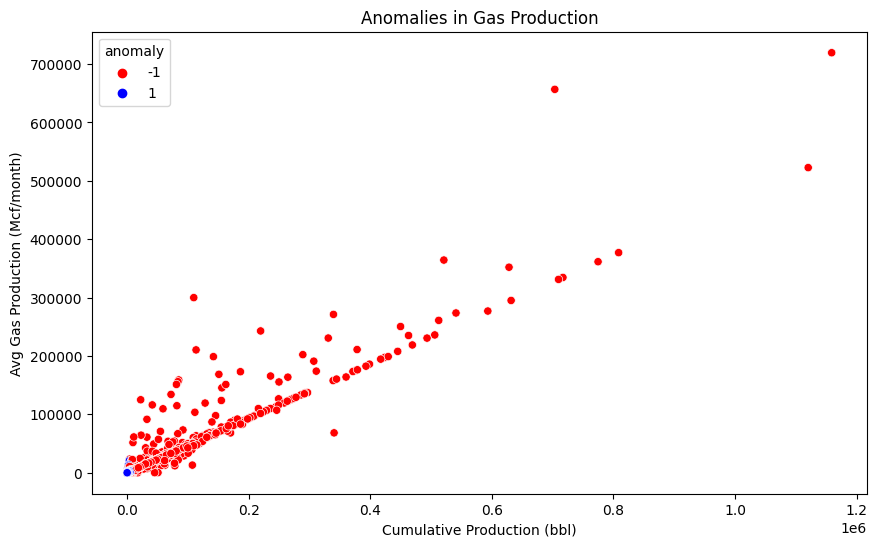

In [30]:
# Visualize the distribution of anomalies vs normal points

# Plot anomalies in Avg Gas Production vs Cumulative Production
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cumulative Production (bbl)', y='Avg Gas Production (Mcf/month)', data=oil_gas_data, hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomalies in Gas Production')
plt.show()

### Anomalies in Gas Production:

Description: The plot shows Avg Gas Production (Mcf/month) on the y-axis and Cumulative Production (bbl) on the x-axis. The red points represent the wells classified as anomalies, while the blue points represent the normal wells.
Insight: We observe that several wells with very high gas production (e.g., over 700,000 Mcf/month) are flagged as anomalies. This suggests that these wells are outliers in terms of their gas production relative to their cumulative production.

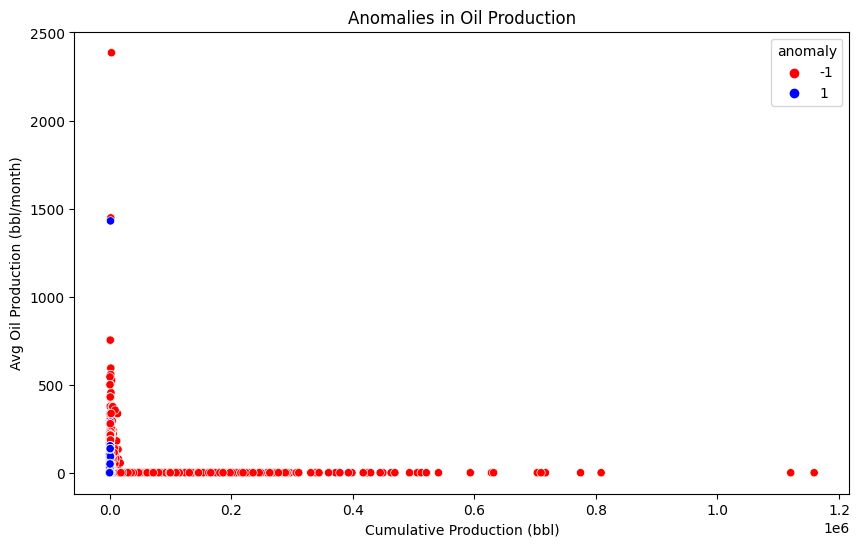

In [31]:
# Visualize anomalies in Avg Oil Production vs Cumulative Production
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cumulative Production (bbl)', y='Avg Oil Production (bbl/month)', data=oil_gas_data, hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomalies in Oil Production')
plt.show()


### Anomalies in Oil Production:

Description: This plot shows Avg Oil Production (bbl/month) on the y-axis and Cumulative Production (bbl) on the x-axis. Wells with anomalous oil production are marked in red.
Insight: Interestingly, most of the anomalies occur at low levels of cumulative oil production. There are a few wells with extremely high average oil production (over 1,000 bbl/month) that are also flagged as anomalies, indicating that these wells exhibit unusual oil production behavior relative to other wells with similar cumulative production.

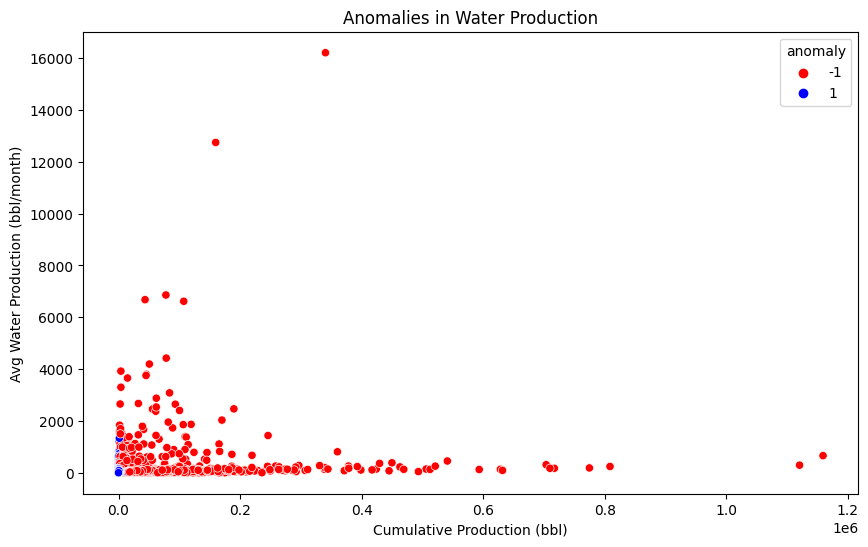

In [32]:
# Visualize anomalies in Avg Water Production vs Cumulative Production
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Cumulative Production (bbl)', y='Avg Water Production (bbl/month)', data=oil_gas_data, hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title('Anomalies in Water Production')
plt.show()


### Anomalies in Water Production:

Description: The plot visualizes Avg Water Production (bbl/month) on the y-axis against Cumulative Production (bbl) on the x-axis. Wells with anomalous water production are indicated in red.
Insight: We observe that wells with very high water production (up to 16,000 bbl/month) have been flagged as anomalies. Similar to the oil production, most of the wells with lower cumulative production are flagged as anomalies when their water production levels are higher than expected.

### Investigate the Detected Anomalies
We will take a closer look at the anomalies flagged by the Isolation Forest model to understand why they were detected as outliers. You can start by reviewing the specific wells that were flagged and compare their features to normal wells.

Here’s a strategy to investigate the anomalies:

* Compare Anomalies with Normal Wells
Review the distribution of features like cumulative production, average production rates (for gas, oil, and water), and other well attributes (e.g., Company Name, Production Field) for the anomalies.
Look for any patterns that stand out—are the anomalous wells concentrated in certain regions, owned by specific companies, or produced during certain years?

In [36]:
# Investigate the anomalies and compare them with non-anomalous wells
anomalies = oil_gas_data[oil_gas_data['anomaly'] == -1]
normal_wells = oil_gas_data[oil_gas_data['anomaly'] == 1]

# Summary statistics for anomalies vs. normal wells
print("Anomalous Wells Summary:")
print(anomalies.describe())



Anomalous Wells Summary:
       API Well Number  API Hole Number  Sidetrack Code  Completion Code  \
count     2.216000e+03      2216.000000     2216.000000      2216.000000   
mean      3.103687e+13     25042.956227        0.094765         0.051444   
std       3.979302e+10     11610.615128        0.341355         0.238634   
min       3.100307e+13      4064.000000        0.000000         0.000000   
25%       3.100925e+13     22747.000000        0.000000         0.000000   
50%       3.101523e+13     23110.000000        0.000000         0.000000   
75%       3.109723e+13     25344.000000        0.000000         0.000000   
max       3.112323e+13     68570.000000        3.000000         3.000000   

       Months in Production  Gas Produced, Mcf  Water Produced, bbl  \
count           2216.000000       2.216000e+03          2216.000000   
mean              10.354242       1.745568e+05          2615.057762   
std                3.069468       4.503679e+05          6370.138934   
min   

In [35]:
print("\nNormal Wells Summary:")
print(normal_wells.describe())


Normal Wells Summary:
       API Well Number  API Hole Number  Sidetrack Code  Completion Code  \
count     2.228160e+05    222816.000000   222816.000000    222816.000000   
mean      3.101997e+13     27566.332333        0.005372         0.014703   
std       2.584466e+10     20113.729462        0.086640         0.129069   
min       3.100300e+13         0.000000        0.000000         0.000000   
25%       3.100914e+13     14839.000000        0.000000         0.000000   
50%       3.101311e+13     19916.000000        0.000000         0.000000   
75%       3.101324e+13     25727.000000        0.000000         0.000000   
max       3.112326e+13     90001.000000        4.000000         3.000000   

       Months in Production  Gas Produced, Mcf  Water Produced, bbl  \
count         222816.000000      222816.000000        222816.000000   
mean               8.581884         941.269983            33.162876   
std                7.696421        2135.956513           216.387637   
min     

### Anomalous Wells Summary:
#### Key Insights:

* Gas Production: The average gas production for anomalous wells is 174,556 Mcf with a very high standard deviation of 450,368 Mcf. This indicates significant variation, and the maximum gas production reaches up to 6,474,551 Mcf, which is extremely high compared to the mean. This suggests that the anomaly detection model has flagged wells with extremely high gas production relative to others.

* Water Production: The average water production for anomalous wells is 2,615 bbl, with some wells producing up to 194,537 bbl. This high variance in water production also indicates that these wells may be outliers in terms of water produced.

* Oil Production: While the average oil production is relatively low at 202.5 bbl, some anomalous wells produce significant amounts of oil, with a maximum of 8,645 bbl.

* Months in Production: Most of the anomalous wells have been producing for a full 12 months, indicating that these anomalies are not necessarily due to wells being newer or less established but rather due to abnormally high production volumes.

* Cumulative Production: The cumulative production for anomalous wells averages 33,907 bbl, but the maximum cumulative production reaches 473,524 bbl, highlighting a few extreme outliers that may be responsible for these wells being flagged as anomalies.

#### Interpretation:

The anomalous wells exhibit extremely high production, especially in terms of gas and water production, and significant variability in these metrics. This suggests that the wells flagged as anomalies are high-producing outliers, which could indicate operational or geological factors that make them highly productive, or potential errors in data recording.
### Normal Wells Summary:
#### Key Insights:

* Gas Production: Normal wells produce much less gas, with an average of only 941 Mcf and a standard deviation of 2,135 Mcf. The maximum production for normal wells is significantly lower than that of the anomalous wells, at 44,688 Mcf.

* Water Production: The average water production for normal wells is very low, at only 33 bbl, compared to the thousands produced by the anomalous wells. This indicates that anomalous wells produce significantly more water.

* Oil Production: Normal wells produce an average of 18.67 bbl of oil, which is much lower than the average for anomalous wells. The maximum oil production for normal wells is 3,509 bbl, far less than the maximum seen for anomalous wells.

* Months in Production: The average production time for normal wells is 8.58 months, slightly shorter than for anomalous wells. This could indicate that some normal wells are either newer or have been operational for shorter periods.

* Cumulative Production: Normal wells have a much lower cumulative production, with an average of 219 bbl and a maximum of 3,509 bbl. This is significantly less than the anomalous wells, further supporting the idea that anomalous wells are outliers in terms of total production.

#### Interpretation:

Normal wells generally exhibit much lower production levels across all metrics (gas, oil, and water). The wells flagged as normal appear to follow typical production trends, with fewer extremes or outliers in their production profiles.

### Key takeaway
The anomalous wells identified by the Isolation Forest model exhibit extremely high production values across gas, oil, and water production metrics, with high variability. These wells are likely flagged as anomalies because they deviate significantly from the typical production patterns observed in normal wells.

These anomalies could indicate:

1. High-performing wells that are operating under exceptional geological or operational conditions.
2. Potential data issues, where reporting errors have led to inflated production numbers.
3. Unique well characteristics, such as specialized equipment or more favorable locations.

Further investigation is needed to determine whether these anomalies are genuine operational outliers or if they result from data entry errors or irregularities.

# Project Conclusion
In this project, we successfully developed a machine learning framework to predict well production and detect anomalies in production data. The Random Forest model proved effective in predicting gas, oil, and water production, achieving robust performance metrics such as low MAE and RMSE, with a high R² score. Cross-validation confirmed the model’s ability to generalize across different data splits.

Through anomaly detection using the Isolation Forest algorithm, we flagged several wells that exhibit unusually high production values, especially in terms of gas and water production. These wells likely represent outliers that may require further investigation for operational or data validation purposes.

## Key Findings 
* Significant Variability in Well Performance:
The anomaly detection model identified wells with extremely high gas, oil, and water production compared to the majority of wells in the dataset. These anomalous wells exhibit production values that are several times higher than normal wells, particularly in gas production, where some wells produced over 6 million Mcf of gas.
The large discrepancies between the anomalous and normal wells suggest that these wells are either outliers due to geological factors, equipment configurations, or data inconsistencies.

* High-Performance Outliers:
Many of the wells flagged as anomalies show consistent production over time, indicating that they may be exceptionally high-performing wells. These wells could be leveraging more efficient drilling techniques, better well placement, or benefiting from favorable geological conditions. Understanding the factors behind these outliers can inform future well development strategies.
 
* Potential Data Quality Issues:
Some anomalous wells display inconsistencies in production data, with extreme outliers in water production reaching up to 194,537 bbl. These anomalies could be the result of data recording errors or misreporting. A focused data validation process is recommended to ensure that these outliers are genuine and not artifacts of incorrect data entry.

* Well Longevity vs. Productivity:
Wells that were in production for fewer months often showed normal production levels, while longer-lived wells tended to produce higher amounts of gas, oil, and water. This suggests that some of the anomalies may be due to well longevity, where older wells have had more time to accumulate higher production totals. This insight could help in differentiating between well performance outliers and expected long-term trends.

* Stable Model Performance:
The Random Forest model demonstrated strong performance, with a high R² score and low MAE and RMSE. The model's ability to generalize across different splits of the data was confirmed through cross-validation, indicating that it can reliably be used for future predictions of well production. This offers valuable foresight into resource planning and allocation of operational efforts.

* Operational and Business Implications:
The flagged anomalies offer actionable insights for operational teams. High-performing outlier wells could serve as benchmarks for optimal well performance, while wells with erratic production could be further investigated for potential operational issues or opportunities for improvement. Addressing these anomalies promptly can enhance the efficiency and profitability of well operations.

### Summary of Key Findings:
1. Wells with extreme production values were flagged as anomalies, offering insights into both potential operational successes and areas of concern.
2. The Random Forest model provided a strong and reliable method for predicting future well production, enabling more informed decision-making in well management.
3. Further investigation is required to confirm whether anomalies are due to exceptional performance, data errors, or operational inefficiencies.
